# Conditional Neural Processes (CNP) for 1D regression.
[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs) were
introduced as a continuation of
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) to extend its training regime to tasks beyond scene rendering, e.g. to
regression and classification.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import datetime
import numpy as np
import torchsnooper
import os
import plotting_utils_cnp as plotting
import data_generator as data
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import dask.dataframe as dd
import import_ipynb
import conditional_neural_process_model as cnp


importing Jupyter notebook from conditional_neural_process_model.ipynb


<img src="../utilities/concept.png" alt="drawing" width="500"/>

## Running Conditional Neural Processes

Now that we have defined the dataset as well as our model and its components we
can start building everything into the graph. Before we get started we need to
set some variables:

*   **`TRAINING_ITERATIONS`** - a scalar that describes the number of iterations
    for training. At each iteration we will sample a new batch of functions from
    the GP, pick some of the points on the curves as our context points **(x,
    y)<sub>C</sub>** and some points as our target points **(x,
    y)<sub>T</sub>**. We will predict the mean and variance at the target points
    given the context and use the log likelihood of the ground truth targets as
    our loss to update the model.
*   **`MAX_CONTEXT_POINTS`** - a scalar that sets the maximum number of contest
    points used during training. The number of context points will then be a
    value between 3 and `MAX_CONTEXT_POINTS` that is sampled at random for every
    iteration.
*   **`PLOT_AFTER`** - a scalar that regulates how often we plot the
    intermediate results.

In [2]:
TRAINING_ITERATIONS = int(3540) # Total number of training points: training_iterations * batch_size * max_content_points
#BATCH_SIZE = 100 # number of simulation configurations

MAX_CONTEXT_POINTS = 1000 # 2000 # 4000
MAX_TARGET_POINTS =  2000 # 4000 # 8000
CONTEXT_IS_SUBSET = True
BATCH_SIZE = 1
CONFIG_WISE = False
PLOT_AFTER = int(500)
torch.manual_seed(0)

# all available x config/ physics parameters are ["radius","thickness","npanels","theta","length","height","z_offset","volume","nC_Ge77","time_0[ms]","x_0[m]","y_0[m]","z_0[m]","px_0[m]","py_0[m]","pz_0[m]","ekin_0[eV]","edep_0[eV]","time_t[ms]","x_t[m]","y_t[m]","z_t[m]","px_t[m]","py_t[m]","pz_t[m]","ekin_t[eV]","edep_t[eV]","nsec"]
# Comment: if using data version v1.1 for training, "radius","thickness","npanels","theta","length" is probably necessary
names_x=["radius","thickness","npanels","theta","length","r_0[m]","z_0[m]","time_t[ms]","r_t[m]","z_t[m]","L_t[m]","ln(E0vsET)","edep_t[eV]","nsec"]
name_y ='total_nC_Ge77[cts]'
x_size = len(names_x)
if isinstance(name_y,str):
    y_size = 1
else:
    y_size = len(name_y)

RATIO_TESTING_VS_TRAINING = 1/40
version_cnp="v1.6"
version_lf="v1.4"

path_to_files=f"../simulation/out/LF/{version_lf}/tier2/"
path_out = f'./out/'
f_out = f'{path_out}CNPGauss_{version_cnp}_{TRAINING_ITERATIONS}_c{MAX_CONTEXT_POINTS}_t{MAX_TARGET_POINTS}'

Data augmentation methods used:

<img src="../utilities/data_augmentation.png" alt="drawing" width="800"/>

In [3]:
# Set data augmentation parameters
USE_DATA_AUGMENTATION = "mixup" #"smote" #False #"mixup"
USE_BETA = [0.1,0.1] # uniform => None, beta => [a,b] U-shape [0.1,0.1] Uniform [1.,1.] falling [0.2,0.5] rising [0.2,0.5]
SIGNAL_TO_BACKGROUND_RATIO = "" # "_1to4" # used for smote augmentation

if USE_DATA_AUGMENTATION:
    path_out = f'./out/{USE_DATA_AUGMENTATION}/'
    f_out = f'CNPGauss_{version_cnp}_{TRAINING_ITERATIONS}_c{MAX_CONTEXT_POINTS}_t{MAX_TARGET_POINTS}_{USE_DATA_AUGMENTATION}{SIGNAL_TO_BACKGROUND_RATIO}'
    if USE_DATA_AUGMENTATION == "mixup":
        path_to_files = f"../simulation/out/LF/{version_lf}/tier3/beta_{USE_BETA[0]}_{USE_BETA[1]}/"
        f_out = f'CNPGauss_{version_cnp}_{TRAINING_ITERATIONS}_c{MAX_CONTEXT_POINTS}_t{MAX_TARGET_POINTS}_beta_{USE_BETA[0]}_{USE_BETA[1]}'
    elif USE_DATA_AUGMENTATION == "smote" and CONFIG_WISE == True:
        path_to_files = f"../simulation/out/LF/{version_lf}/tier3/smote{SIGNAL_TO_BACKGROUND_RATIO}/"
        

In [4]:
# Train dataset
dataset_train = data.DataGeneration(num_iterations=TRAINING_ITERATIONS, num_context_points=MAX_CONTEXT_POINTS, num_target_points=MAX_TARGET_POINTS, batch_size = BATCH_SIZE, config_wise=CONFIG_WISE, path_to_files=path_to_files,x_size=x_size,y_size=y_size, mode = "training", ratio_testing=RATIO_TESTING_VS_TRAINING,sig_bkg_ratio = SIGNAL_TO_BACKGROUND_RATIO, use_data_augmentation=USE_DATA_AUGMENTATION, names_x = names_x, name_y=name_y)
TRAINING_ITERATIONS = dataset_train._num_iterations
# Testing dataset
dataset_testing = data.DataGeneration(num_iterations=int(np.round(TRAINING_ITERATIONS/PLOT_AFTER))+5, num_context_points=MAX_CONTEXT_POINTS, num_target_points=MAX_TARGET_POINTS, batch_size = 1, config_wise=False, path_to_files=f"../simulation/out/LF/{version_lf}/tier2/",x_size=x_size,y_size=y_size, mode = "testing",ratio_testing=RATIO_TESTING_VS_TRAINING, sig_bkg_ratio = SIGNAL_TO_BACKGROUND_RATIO, use_data_augmentation="None", names_x = names_x, name_y=name_y)
TRAINING_ITERATIONS = dataset_train._num_iterations if TRAINING_ITERATIONS > dataset_train._num_iterations else TRAINING_ITERATIONS
PLOT_AFTER =  int(5 * np.ceil(np.ceil(TRAINING_ITERATIONS/(dataset_testing._num_iterations-2))/5)) if PLOT_AFTER < int(np.ceil(TRAINING_ITERATIONS/(dataset_testing._num_iterations-2))) else PLOT_AFTER


We can now add the model to the graph and finalise it by defining the train step
and the initializer.

2024-09-27 17:54:41 Iteration: 0/3540, train loss: 204.9993 (vs BCE 0.6934)
2024-09-27 17:54:42, Iteration: 0, test loss: 234.6604 (vs BCE 0.6773)


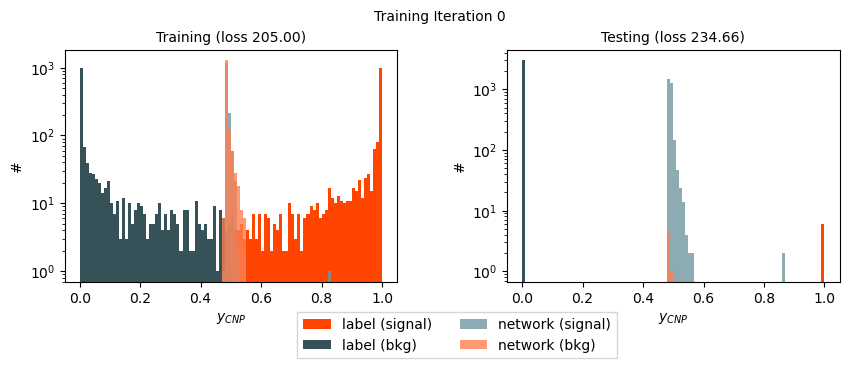

2024-09-27 17:57:02 Iteration: 500/3540, train loss: 166.3883 (vs BCE 0.6240)
2024-09-27 17:57:02, Iteration: 500, test loss: 158.6883 (vs BCE 0.6709)


<Figure size 640x480 with 0 Axes>

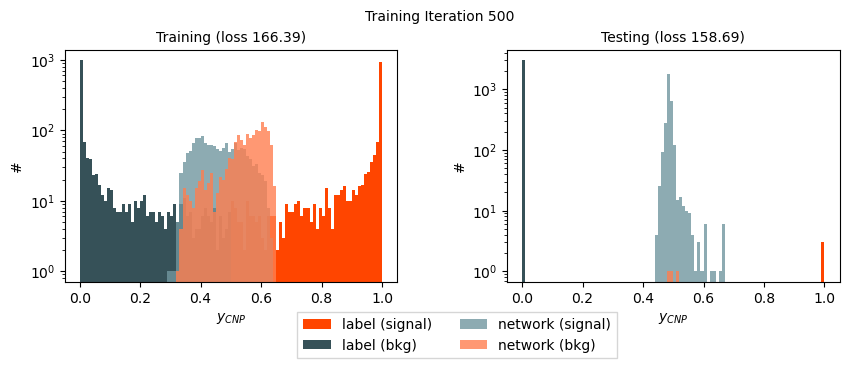

2024-09-27 17:59:31 Iteration: 1000/3540, train loss: 89.7087 (vs BCE 0.4766)
2024-09-27 17:59:31, Iteration: 1000, test loss: 117.3013 (vs BCE 0.4273)


<Figure size 640x480 with 0 Axes>

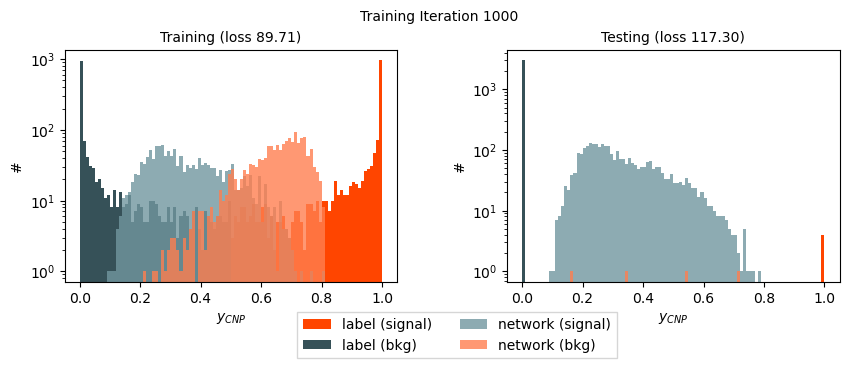

2024-09-27 18:01:58 Iteration: 1500/3540, train loss: 64.2090 (vs BCE 0.3988)
2024-09-27 18:01:58, Iteration: 1500, test loss: 143.9639 (vs BCE 0.4562)


<Figure size 640x480 with 0 Axes>

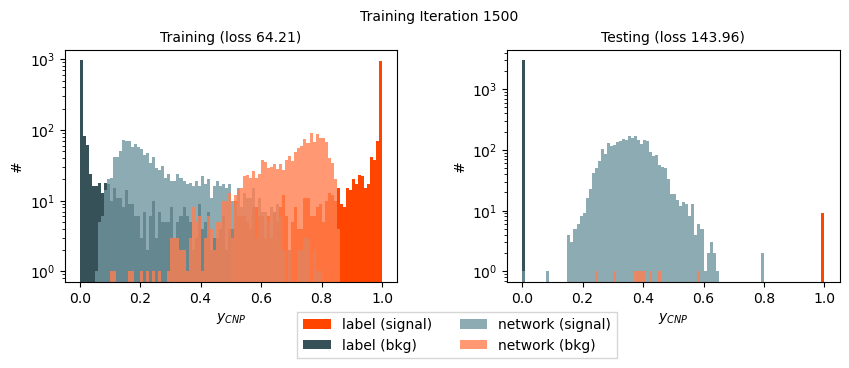

2024-09-27 18:04:24 Iteration: 2000/3540, train loss: 58.0155 (vs BCE 0.4061)
2024-09-27 18:04:25, Iteration: 2000, test loss: 83.4533 (vs BCE 0.3608)


<Figure size 640x480 with 0 Axes>

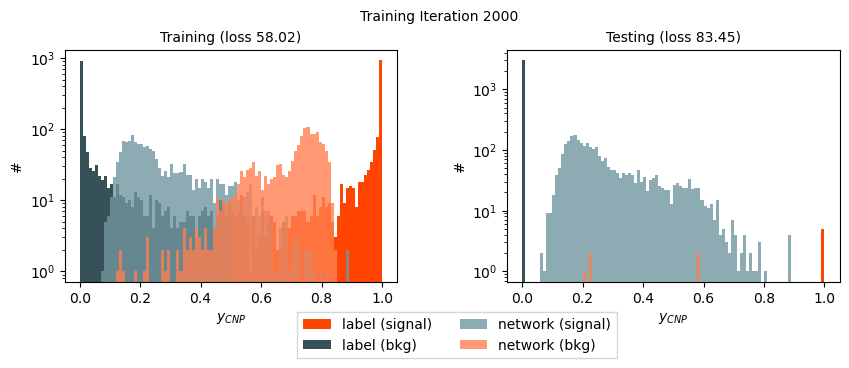

2024-09-27 18:06:54 Iteration: 2500/3540, train loss: 41.7220 (vs BCE 0.3617)
2024-09-27 18:06:54, Iteration: 2500, test loss: 73.8547 (vs BCE 0.3626)


<Figure size 640x480 with 0 Axes>

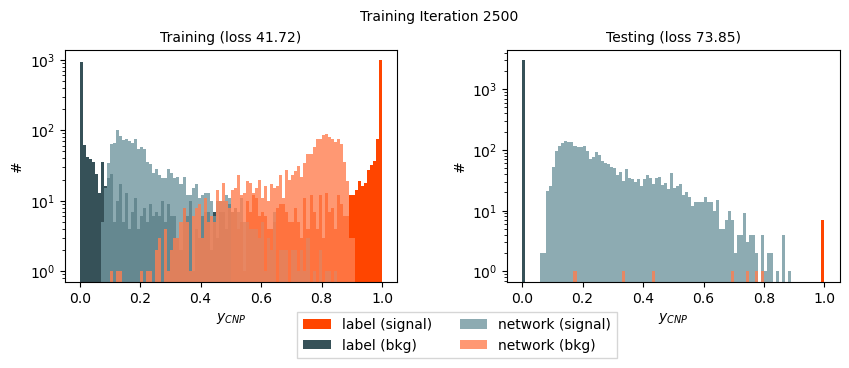

2024-09-27 18:09:29 Iteration: 3000/3540, train loss: 44.4079 (vs BCE 0.3705)
2024-09-27 18:09:29, Iteration: 3000, test loss: 53.7501 (vs BCE 0.2842)


<Figure size 640x480 with 0 Axes>

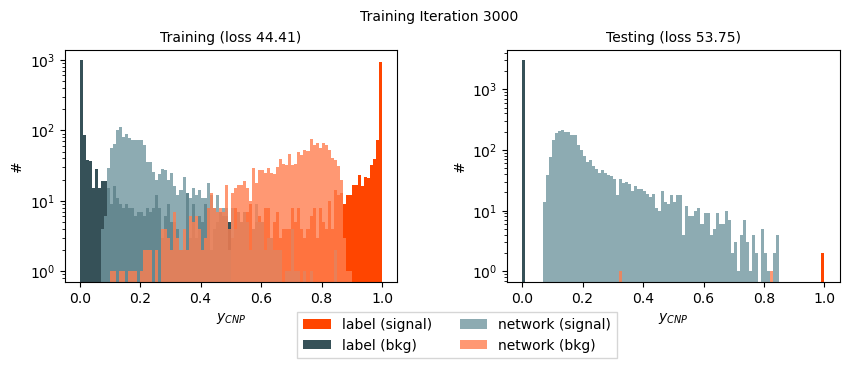

2024-09-27 18:11:31 Iteration: 3401/3540, train loss: 39.0438 (vs BCE 0.3387)
2024-09-27 18:11:31 Iteration: 3402/3540, train loss: 40.8307 (vs BCE 0.3428)
2024-09-27 18:11:31 Iteration: 3403/3540, train loss: 37.7623 (vs BCE 0.3312)
2024-09-27 18:11:32 Iteration: 3404/3540, train loss: 40.0622 (vs BCE 0.3393)
2024-09-27 18:11:32 Iteration: 3405/3540, train loss: 39.5558 (vs BCE 0.3344)
2024-09-27 18:11:32 Iteration: 3406/3540, train loss: 39.2970 (vs BCE 0.3265)
2024-09-27 18:11:33 Iteration: 3407/3540, train loss: 39.2355 (vs BCE 0.3322)
2024-09-27 18:11:33 Iteration: 3408/3540, train loss: 42.0477 (vs BCE 0.3509)
2024-09-27 18:11:33 Iteration: 3409/3540, train loss: 38.6802 (vs BCE 0.3293)
2024-09-27 18:11:34 Iteration: 3410/3540, train loss: 39.0639 (vs BCE 0.3306)
2024-09-27 18:11:34 Iteration: 3411/3540, train loss: 38.2936 (vs BCE 0.3363)
2024-09-27 18:11:34 Iteration: 3412/3540, train loss: 38.9589 (vs BCE 0.3351)
2024-09-27 18:11:35 Iteration: 3413/3540, train loss: 38.9963 (v

<Figure size 640x480 with 0 Axes>

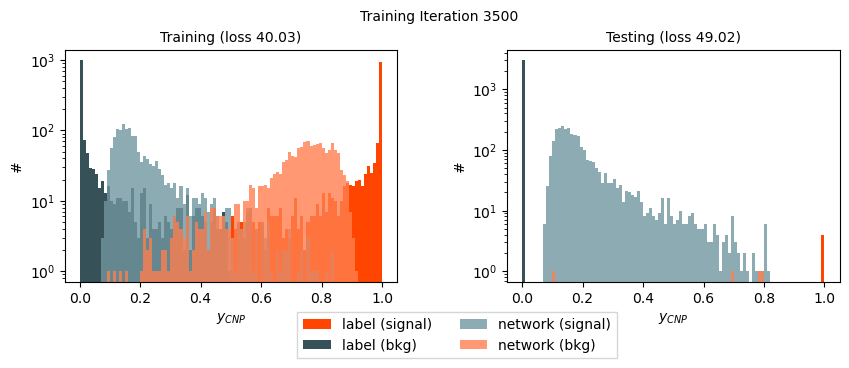

2024-09-27 18:12:05 Iteration: 3501/3540, train loss: 40.0532 (vs BCE 0.3649)
2024-09-27 18:12:05, Iteration: 3501, test loss: 48.4577 (vs BCE 0.2462)


<Figure size 640x480 with 0 Axes>

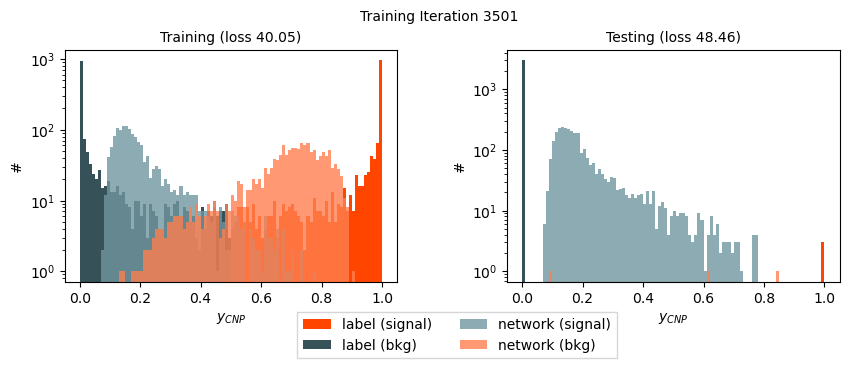

2024-09-27 18:12:07 Iteration: 3502/3540, train loss: 41.2291 (vs BCE 0.3598)
2024-09-27 18:12:08, Iteration: 3502, test loss: 48.1413 (vs BCE 0.2443)


<Figure size 640x480 with 0 Axes>

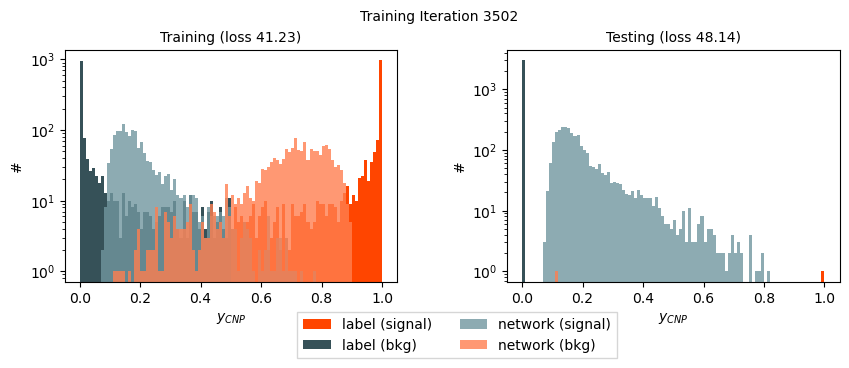

2024-09-27 18:12:10 Iteration: 3503/3540, train loss: 37.3310 (vs BCE 0.3433)
2024-09-27 18:12:10, Iteration: 3503, test loss: 49.3613 (vs BCE 0.2574)


<Figure size 640x480 with 0 Axes>

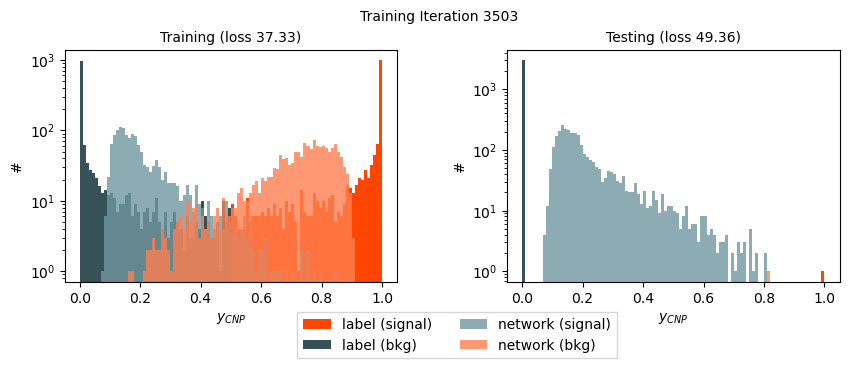

2024-09-27 18:12:12 Iteration: 3504/3540, train loss: 37.6706 (vs BCE 0.3451)
2024-09-27 18:12:12, Iteration: 3504, test loss: 54.1005 (vs BCE 0.2765)


<Figure size 640x480 with 0 Axes>

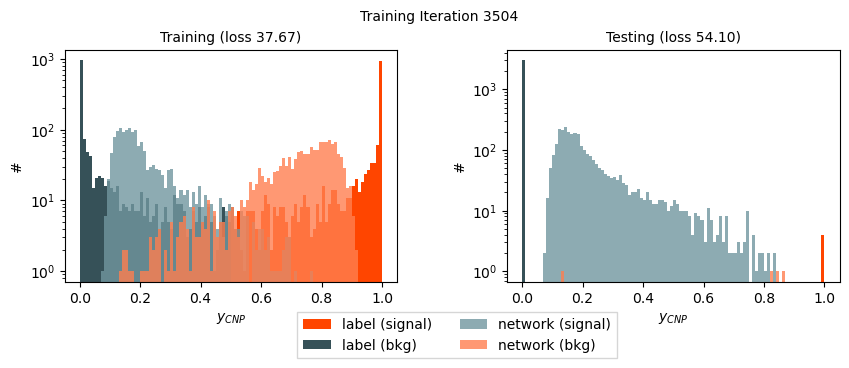

2024-09-27 18:12:14 Iteration: 3505/3540, train loss: 38.3299 (vs BCE 0.3417)
2024-09-27 18:12:14, Iteration: 3505, test loss: 52.3875 (vs BCE 0.2717)


<Figure size 640x480 with 0 Axes>

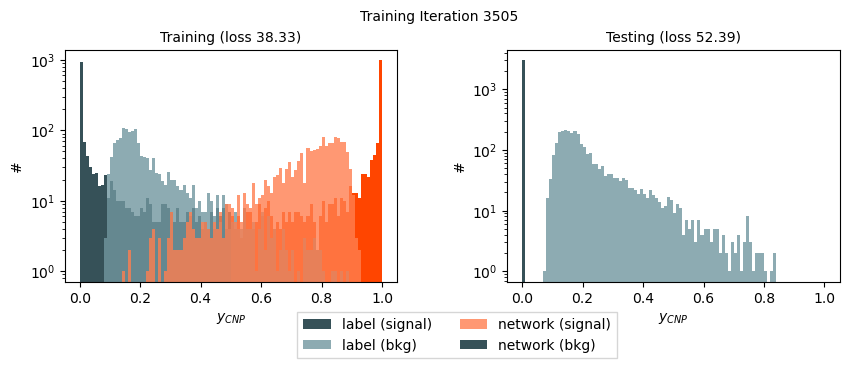

2024-09-27 18:12:16 Iteration: 3506/3540, train loss: 36.3281 (vs BCE 0.3234)
2024-09-27 18:12:16, Iteration: 3506, test loss: 62.0485 (vs BCE 0.3097)


<Figure size 640x480 with 0 Axes>

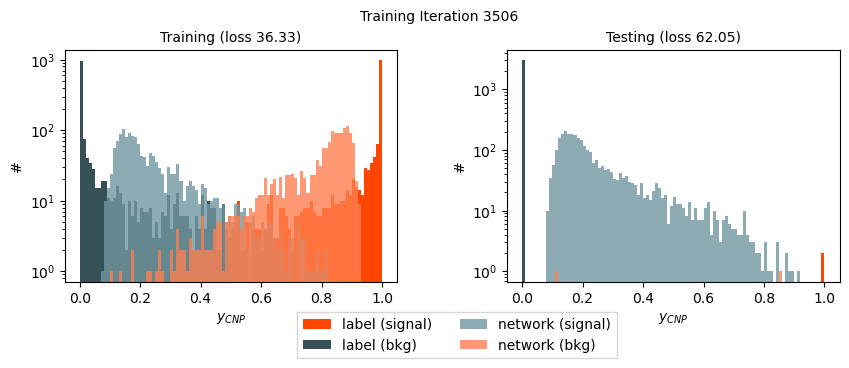

2024-09-27 18:12:18 Iteration: 3507/3540, train loss: 39.0642 (vs BCE 0.3406)
2024-09-27 18:12:18, Iteration: 3507, test loss: 64.9395 (vs BCE 0.3215)


<Figure size 640x480 with 0 Axes>

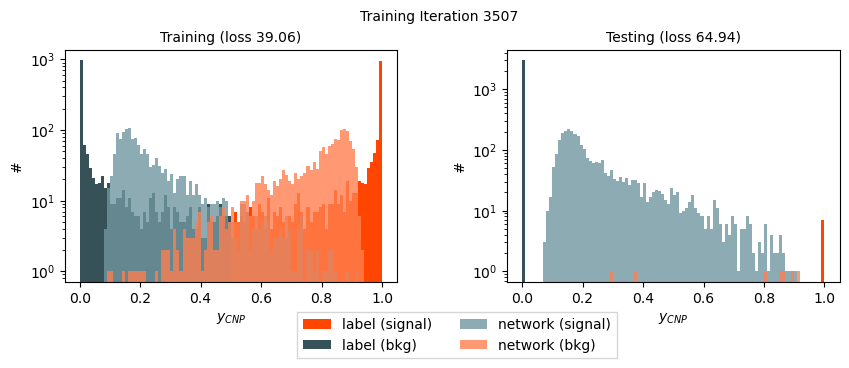

2024-09-27 18:12:20 Iteration: 3508/3540, train loss: 39.8557 (vs BCE 0.3321)
2024-09-27 18:12:20, Iteration: 3508, test loss: 60.3527 (vs BCE 0.3006)


<Figure size 640x480 with 0 Axes>

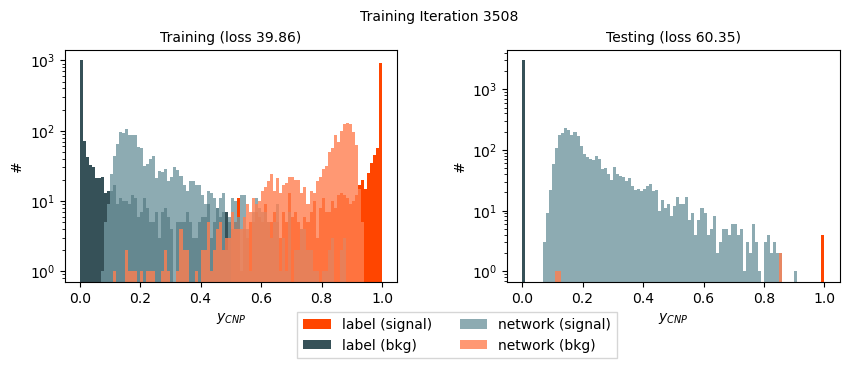

2024-09-27 18:12:22 Iteration: 3509/3540, train loss: 42.8893 (vs BCE 0.3482)
2024-09-27 18:12:22, Iteration: 3509, test loss: 52.2497 (vs BCE 0.2611)


<Figure size 640x480 with 0 Axes>

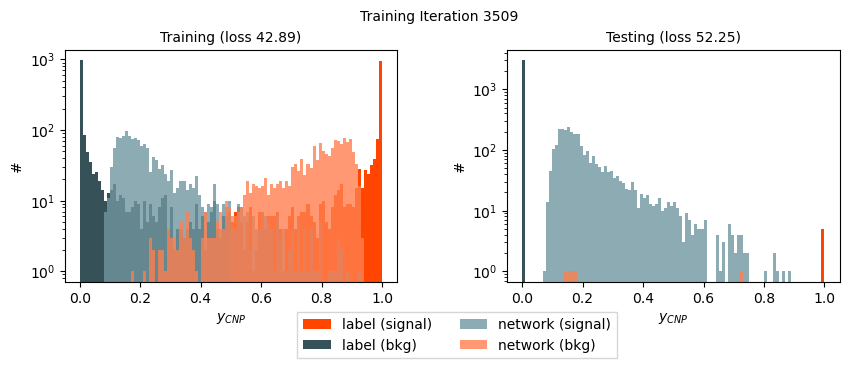

2024-09-27 18:12:24 Iteration: 3510/3540, train loss: 37.5614 (vs BCE 0.3236)
2024-09-27 18:12:25, Iteration: 3510, test loss: 52.2512 (vs BCE 0.2638)


<Figure size 640x480 with 0 Axes>

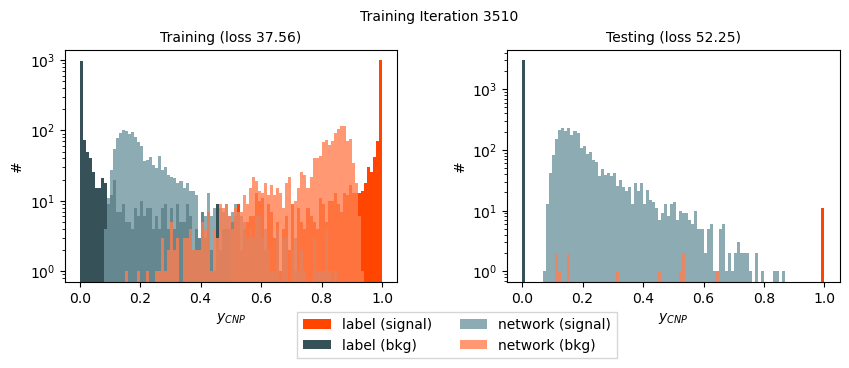

2024-09-27 18:12:26 Iteration: 3511/3540, train loss: 39.9878 (vs BCE 0.3370)
2024-09-27 18:12:27, Iteration: 3511, test loss: 49.8224 (vs BCE 0.2510)


<Figure size 640x480 with 0 Axes>

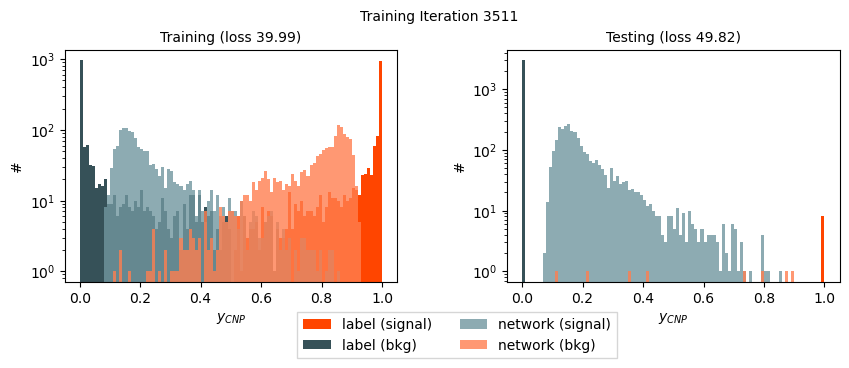

2024-09-27 18:12:29 Iteration: 3512/3540, train loss: 39.8397 (vs BCE 0.3509)
2024-09-27 18:12:29, Iteration: 3512, test loss: 64.0204 (vs BCE 0.2997)


<Figure size 640x480 with 0 Axes>

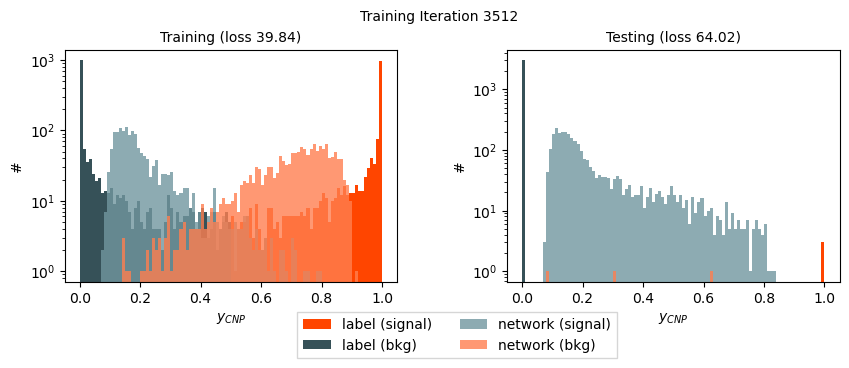

2024-09-27 18:12:31 Iteration: 3513/3540, train loss: 39.4792 (vs BCE 0.3478)
2024-09-27 18:12:31, Iteration: 3513, test loss: 52.1047 (vs BCE 0.2639)


<Figure size 640x480 with 0 Axes>

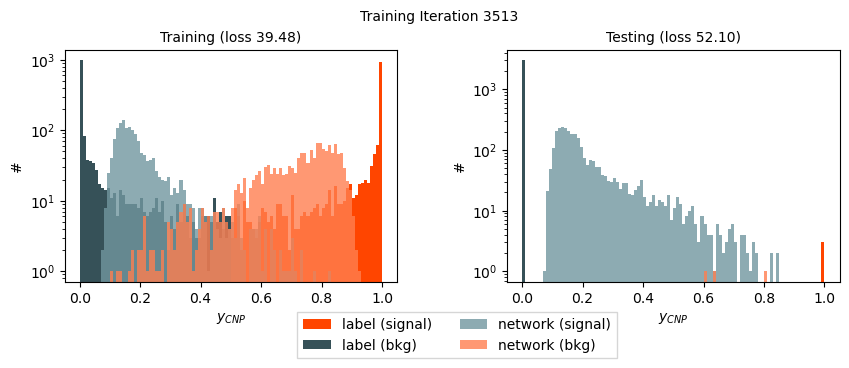

2024-09-27 18:12:33 Iteration: 3514/3540, train loss: 39.9278 (vs BCE 0.3500)
2024-09-27 18:12:33, Iteration: 3514, test loss: 50.9791 (vs BCE 0.2579)


<Figure size 640x480 with 0 Axes>

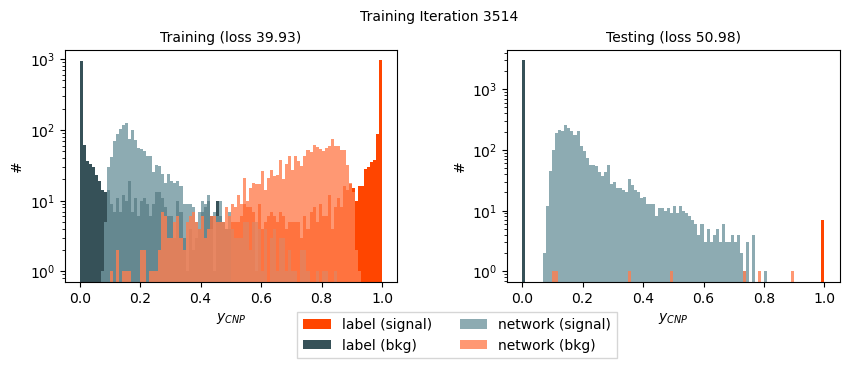

2024-09-27 18:12:35 Iteration: 3515/3540, train loss: 38.2604 (vs BCE 0.3373)
2024-09-27 18:12:35, Iteration: 3515, test loss: 58.0109 (vs BCE 0.2930)


<Figure size 640x480 with 0 Axes>

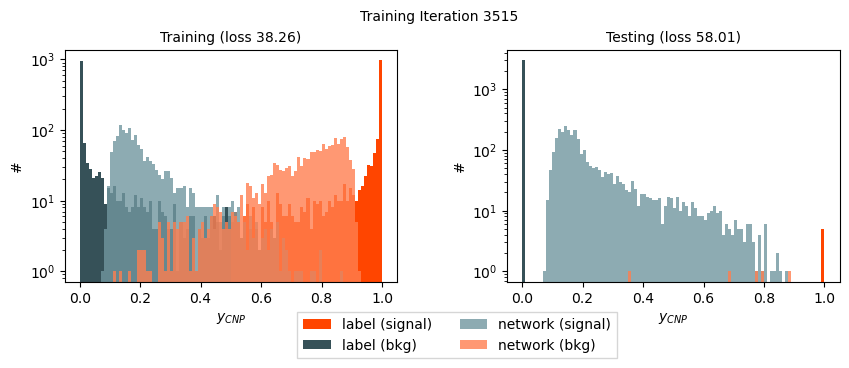

2024-09-27 18:12:37 Iteration: 3516/3540, train loss: 37.2345 (vs BCE 0.3323)
2024-09-27 18:12:37, Iteration: 3516, test loss: 57.8247 (vs BCE 0.2944)


<Figure size 640x480 with 0 Axes>

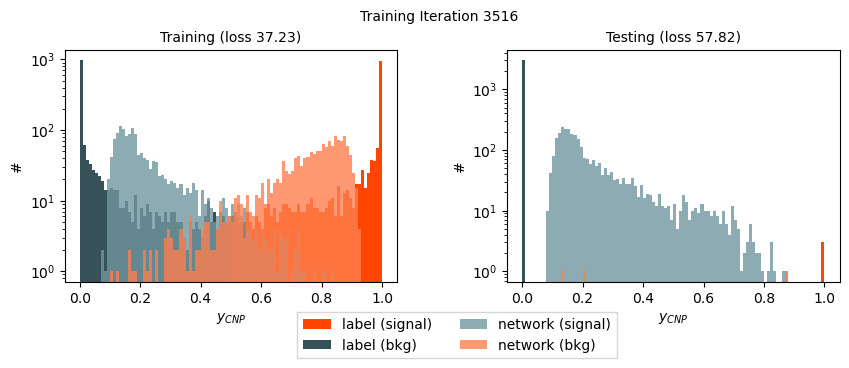

2024-09-27 18:12:40 Iteration: 3517/3540, train loss: 39.0734 (vs BCE 0.3358)
2024-09-27 18:12:40, Iteration: 3517, test loss: 59.2588 (vs BCE 0.2964)


<Figure size 640x480 with 0 Axes>

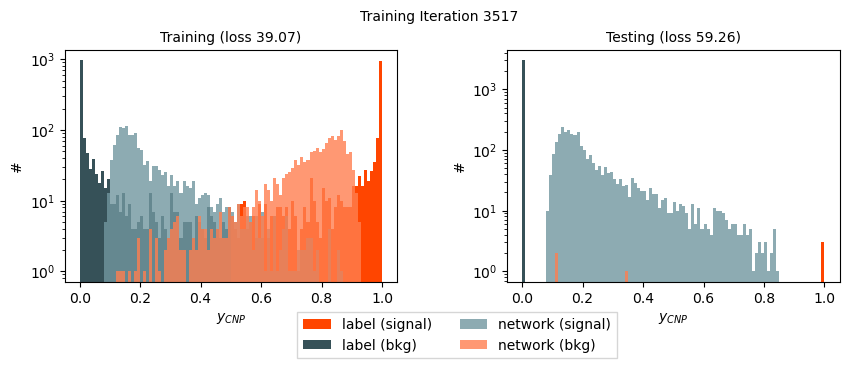

2024-09-27 18:12:42 Iteration: 3518/3540, train loss: 39.5195 (vs BCE 0.3291)
2024-09-27 18:12:42, Iteration: 3518, test loss: 56.6253 (vs BCE 0.2883)


<Figure size 640x480 with 0 Axes>

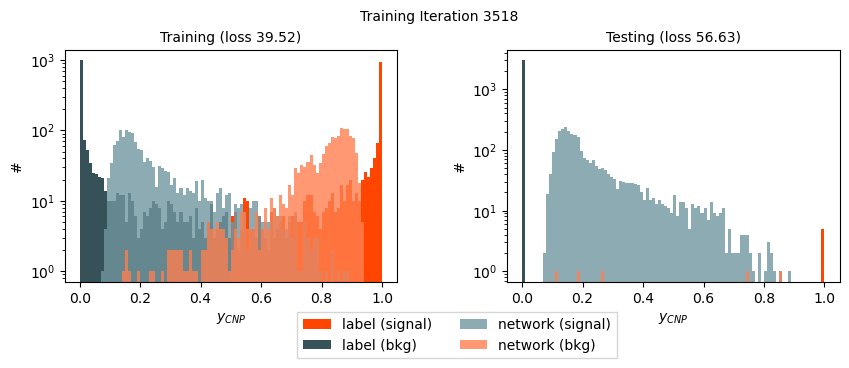

2024-09-27 18:12:44 Iteration: 3519/3540, train loss: 39.8301 (vs BCE 0.3362)
2024-09-27 18:12:44, Iteration: 3519, test loss: 54.7035 (vs BCE 0.2735)


<Figure size 640x480 with 0 Axes>

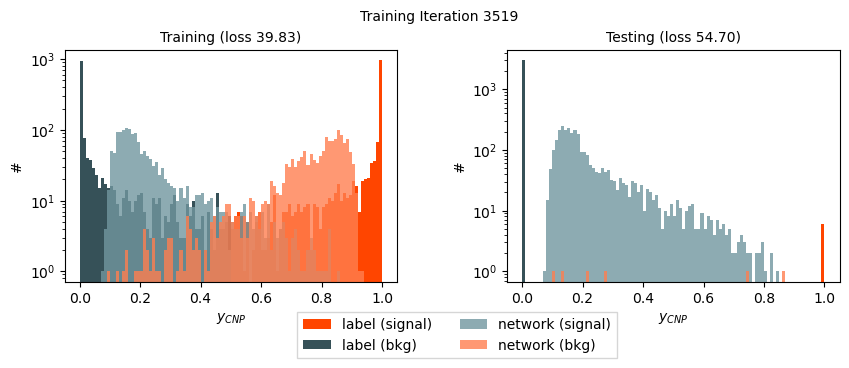

2024-09-27 18:12:46 Iteration: 3520/3540, train loss: 37.8160 (vs BCE 0.3260)
2024-09-27 18:12:47, Iteration: 3520, test loss: 71.6944 (vs BCE 0.3362)


<Figure size 640x480 with 0 Axes>

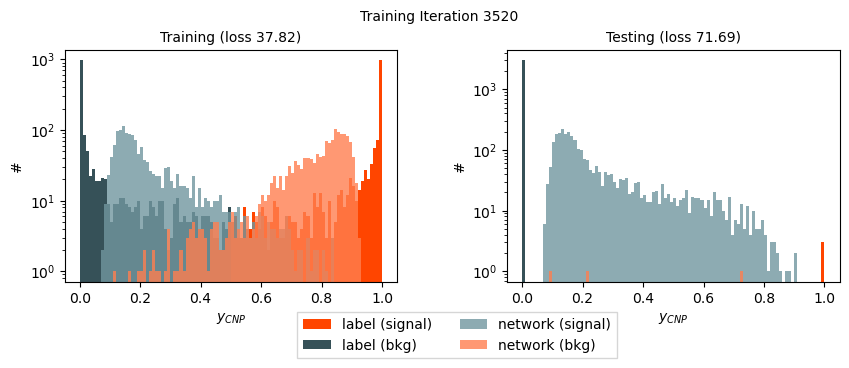

2024-09-27 18:12:49 Iteration: 3521/3540, train loss: 38.9175 (vs BCE 0.3462)
2024-09-27 18:12:49, Iteration: 3521, test loss: 46.9836 (vs BCE 0.2443)


<Figure size 640x480 with 0 Axes>

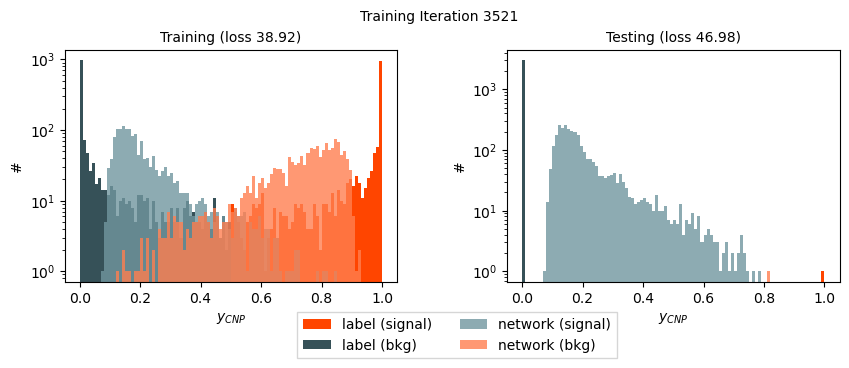

2024-09-27 18:12:51 Iteration: 3522/3540, train loss: 39.0395 (vs BCE 0.3491)
2024-09-27 18:12:51, Iteration: 3522, test loss: 54.1231 (vs BCE 0.2799)


<Figure size 640x480 with 0 Axes>

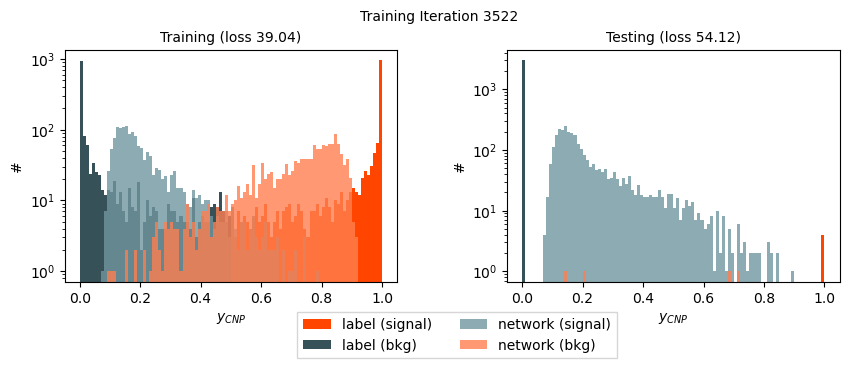

2024-09-27 18:12:53 Iteration: 3523/3540, train loss: 40.1728 (vs BCE 0.3456)
2024-09-27 18:12:53, Iteration: 3523, test loss: 55.0290 (vs BCE 0.2772)


<Figure size 640x480 with 0 Axes>

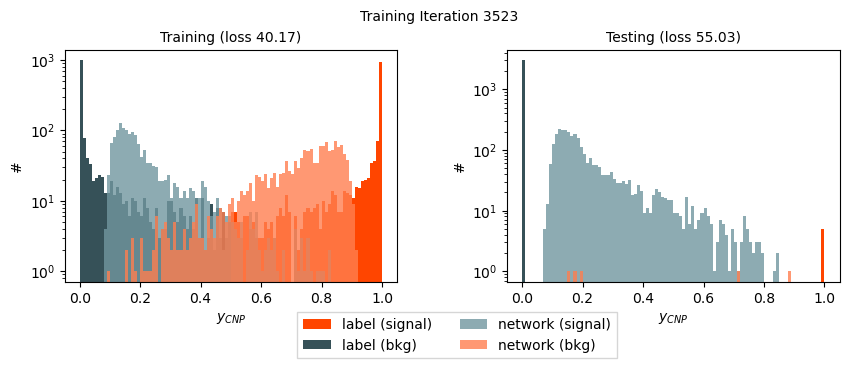

2024-09-27 18:12:55 Iteration: 3524/3540, train loss: 39.0100 (vs BCE 0.3411)
2024-09-27 18:12:56, Iteration: 3524, test loss: 284.1237 (vs BCE 0.7269)


<Figure size 640x480 with 0 Axes>

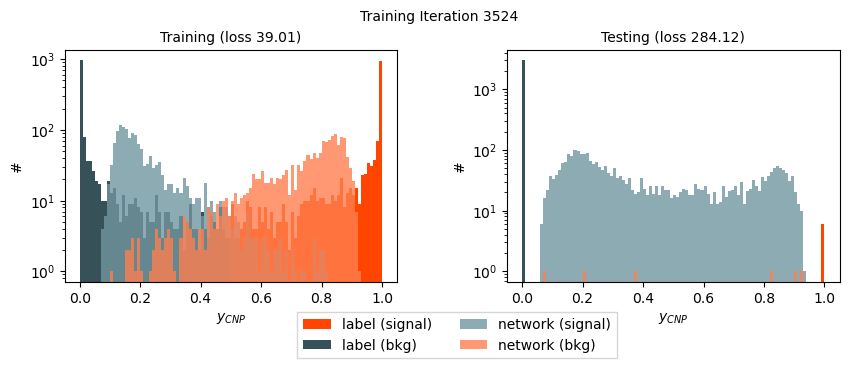

2024-09-27 18:12:58 Iteration: 3525/3540, train loss: 36.6742 (vs BCE 0.3322)
2024-09-27 18:12:58, Iteration: 3525, test loss: 49.4136 (vs BCE 0.2574)


<Figure size 640x480 with 0 Axes>

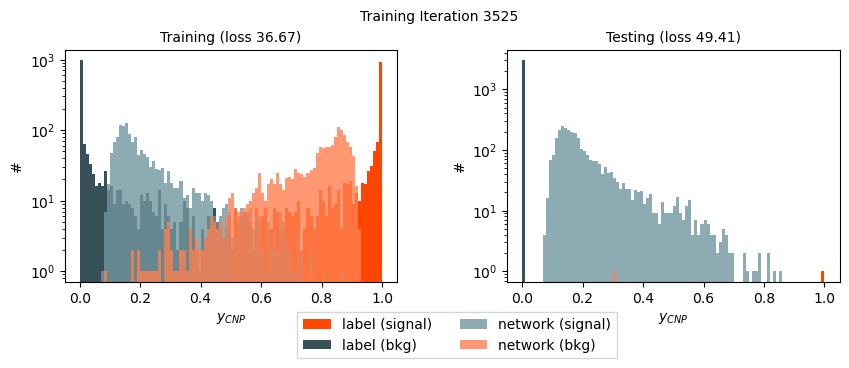

2024-09-27 18:13:00 Iteration: 3526/3540, train loss: 37.9884 (vs BCE 0.3278)
2024-09-27 18:13:00, Iteration: 3526, test loss: 114.1686 (vs BCE 0.4464)


<Figure size 640x480 with 0 Axes>

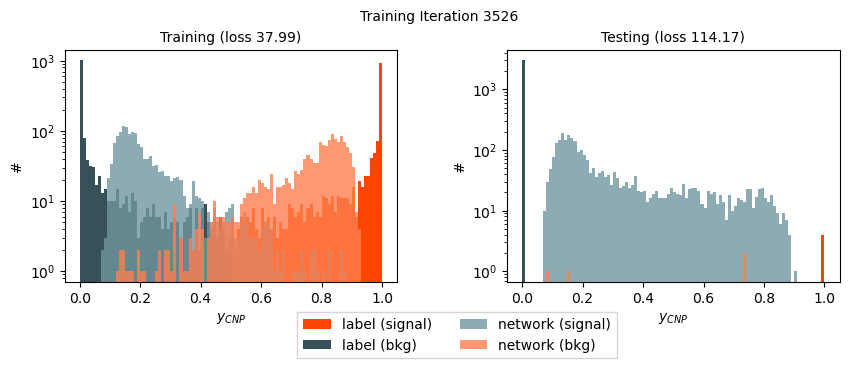

2024-09-27 18:13:02 Iteration: 3527/3540, train loss: 37.6841 (vs BCE 0.3256)
2024-09-27 18:13:02, Iteration: 3527, test loss: 56.3676 (vs BCE 0.2859)


<Figure size 640x480 with 0 Axes>

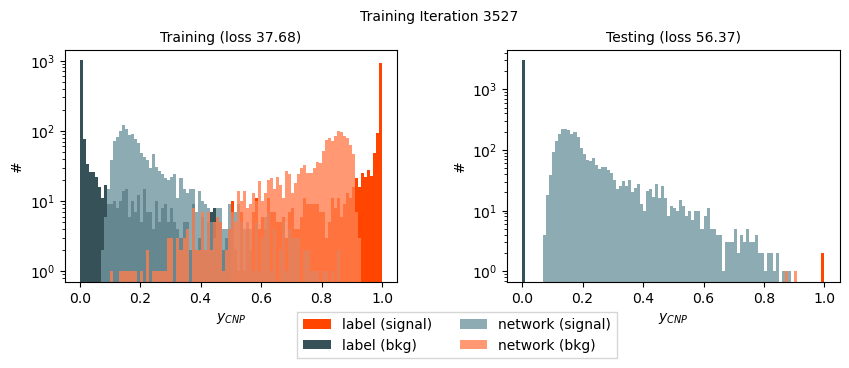

2024-09-27 18:13:04 Iteration: 3528/3540, train loss: 36.9707 (vs BCE 0.3305)
2024-09-27 18:13:05, Iteration: 3528, test loss: 60.8078 (vs BCE 0.3062)


<Figure size 640x480 with 0 Axes>

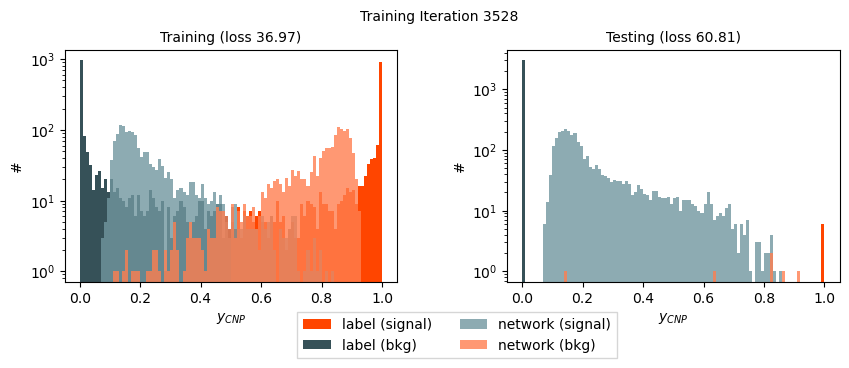

2024-09-27 18:13:06 Iteration: 3529/3540, train loss: 38.7644 (vs BCE 0.3361)
2024-09-27 18:13:07, Iteration: 3529, test loss: 103.4949 (vs BCE 0.4115)


<Figure size 640x480 with 0 Axes>

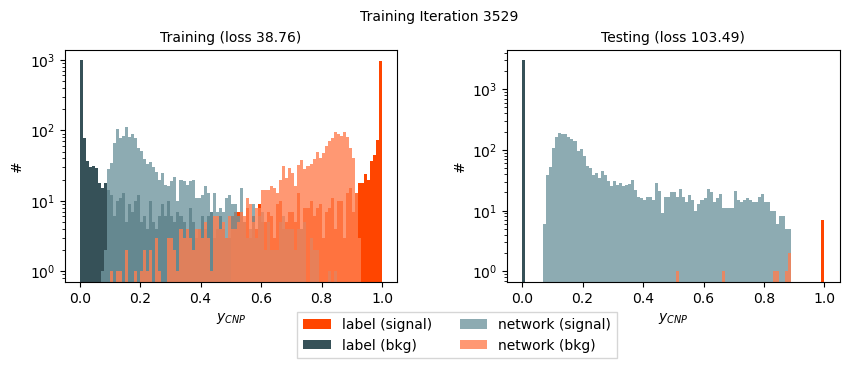

2024-09-27 18:13:09 Iteration: 3530/3540, train loss: 35.5674 (vs BCE 0.3265)
2024-09-27 18:13:09, Iteration: 3530, test loss: 52.8152 (vs BCE 0.2683)


<Figure size 640x480 with 0 Axes>

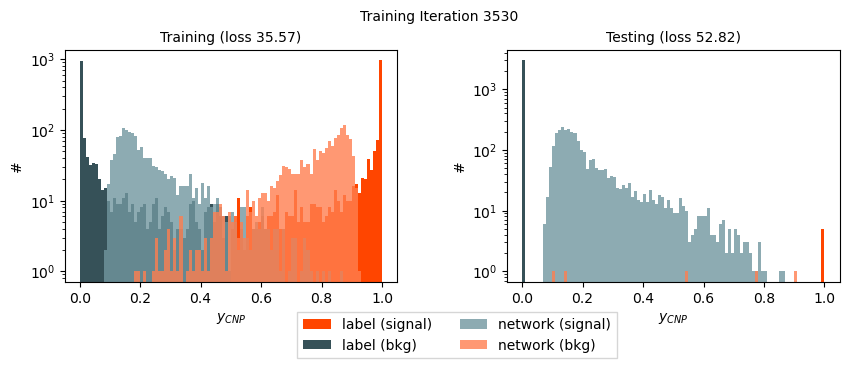

2024-09-27 18:13:11 Iteration: 3531/3540, train loss: 39.1146 (vs BCE 0.3359)
2024-09-27 18:13:11, Iteration: 3531, test loss: 51.2095 (vs BCE 0.2663)


<Figure size 640x480 with 0 Axes>

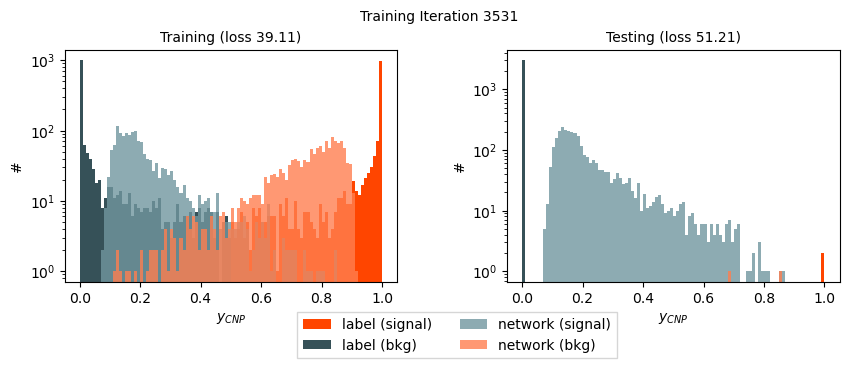

2024-09-27 18:13:13 Iteration: 3532/3540, train loss: 36.4233 (vs BCE 0.3338)
2024-09-27 18:13:13, Iteration: 3532, test loss: 55.1317 (vs BCE 0.2734)


<Figure size 640x480 with 0 Axes>

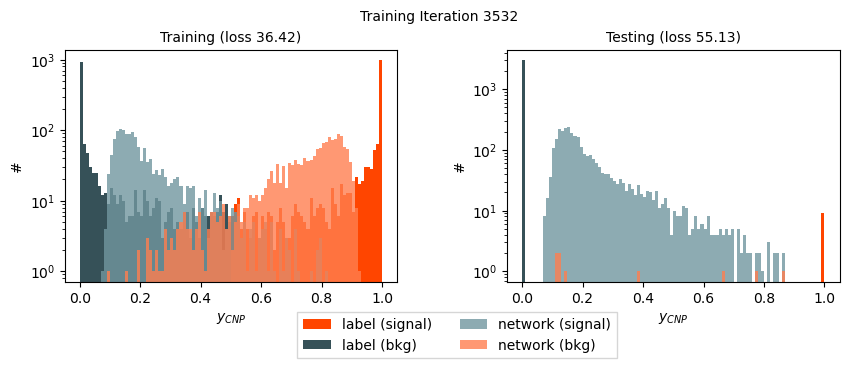

2024-09-27 18:13:15 Iteration: 3533/3540, train loss: 39.8980 (vs BCE 0.3402)
2024-09-27 18:13:15, Iteration: 3533, test loss: 70.5532 (vs BCE 0.3367)


<Figure size 640x480 with 0 Axes>

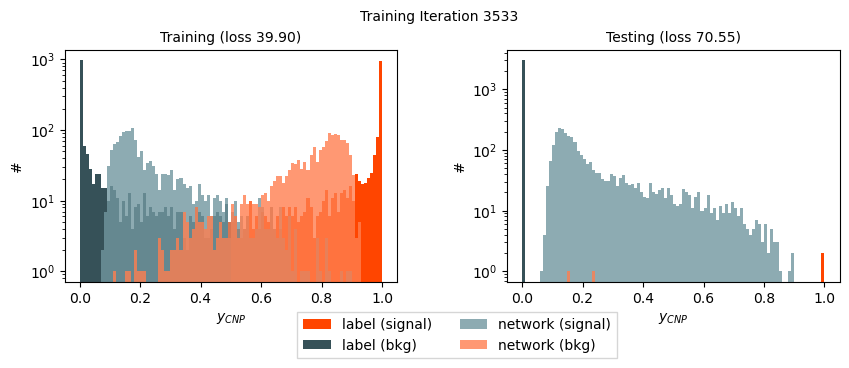

2024-09-27 18:13:17 Iteration: 3534/3540, train loss: 37.4671 (vs BCE 0.3329)
2024-09-27 18:13:18, Iteration: 3534, test loss: 51.4492 (vs BCE 0.2675)


<Figure size 640x480 with 0 Axes>

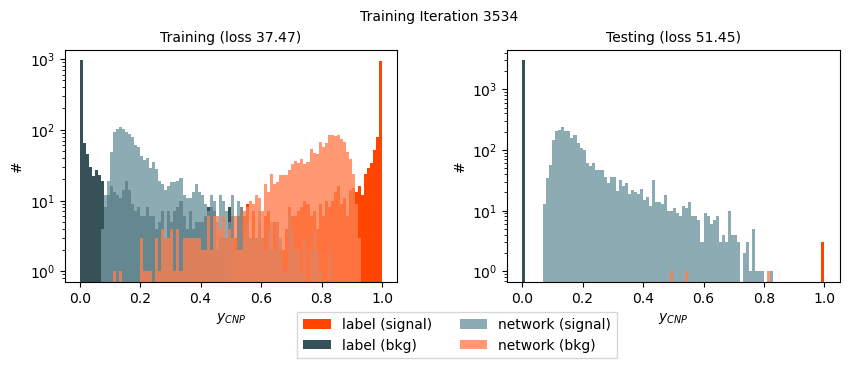

2024-09-27 18:13:20 Iteration: 3535/3540, train loss: 37.4832 (vs BCE 0.3342)
2024-09-27 18:13:20, Iteration: 3535, test loss: 56.5120 (vs BCE 0.2801)


<Figure size 640x480 with 0 Axes>

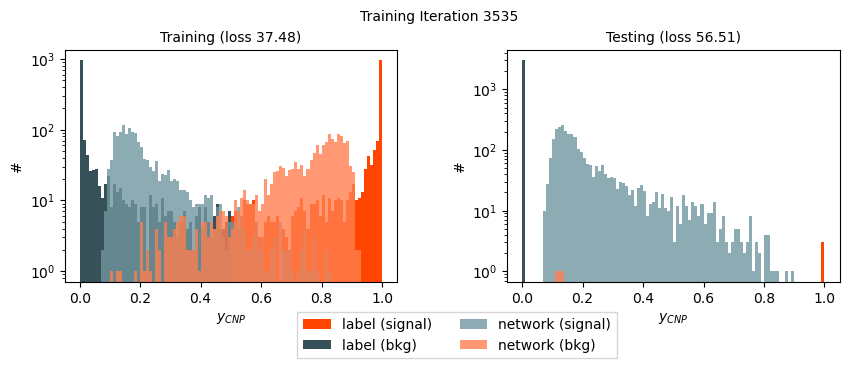

2024-09-27 18:13:22 Iteration: 3536/3540, train loss: 38.4823 (vs BCE 0.3455)
2024-09-27 18:13:22, Iteration: 3536, test loss: 90.6064 (vs BCE 0.3761)


<Figure size 640x480 with 0 Axes>

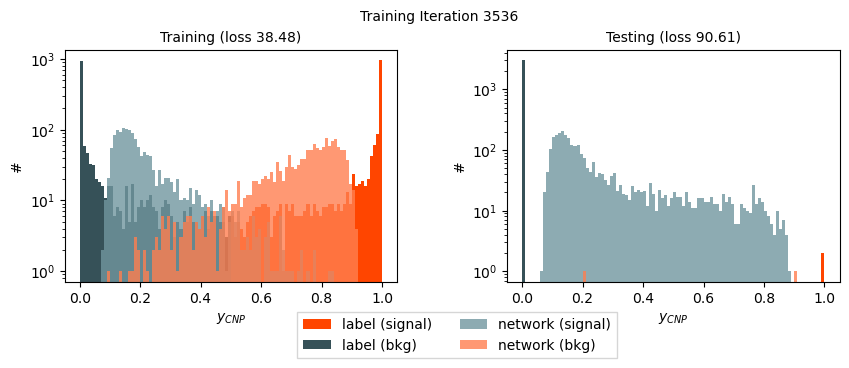

2024-09-27 18:13:24 Iteration: 3537/3540, train loss: 37.5319 (vs BCE 0.3442)
2024-09-27 18:13:24, Iteration: 3537, test loss: 49.4587 (vs BCE 0.2550)


<Figure size 640x480 with 0 Axes>

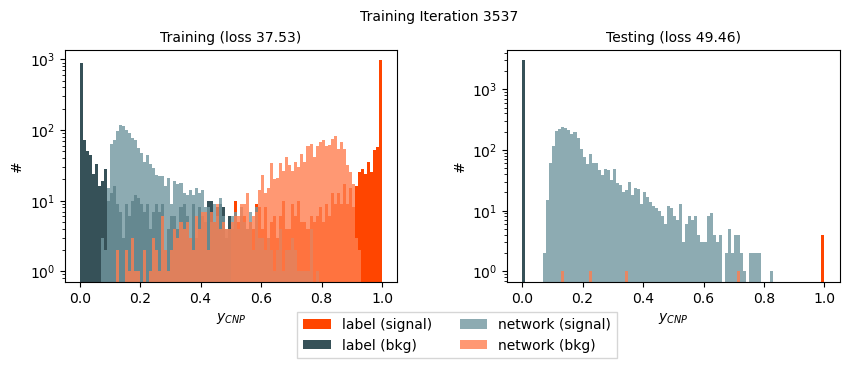

2024-09-27 18:13:26 Iteration: 3538/3540, train loss: 37.9986 (vs BCE 0.3353)
2024-09-27 18:13:26, Iteration: 3538, test loss: 84.8260 (vs BCE 0.3621)


<Figure size 640x480 with 0 Axes>

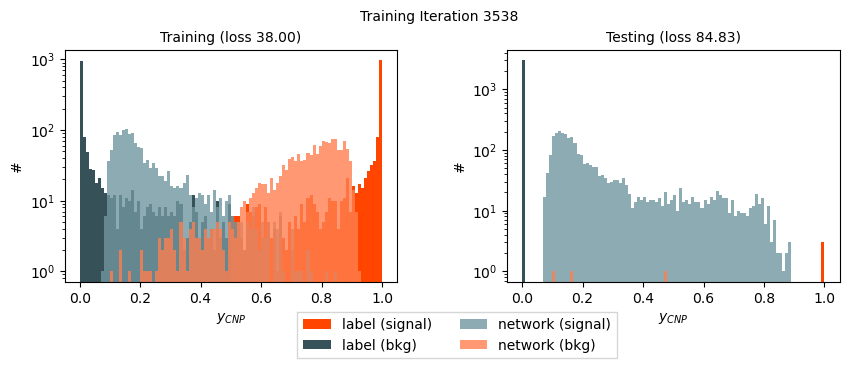

2024-09-27 18:13:28 Iteration: 3539/3540, train loss: 46.1623 (vs BCE 0.3520)
2024-09-27 18:13:28, Iteration: 3539, test loss: 49.0991 (vs BCE 0.2499)


<Figure size 640x480 with 0 Axes>

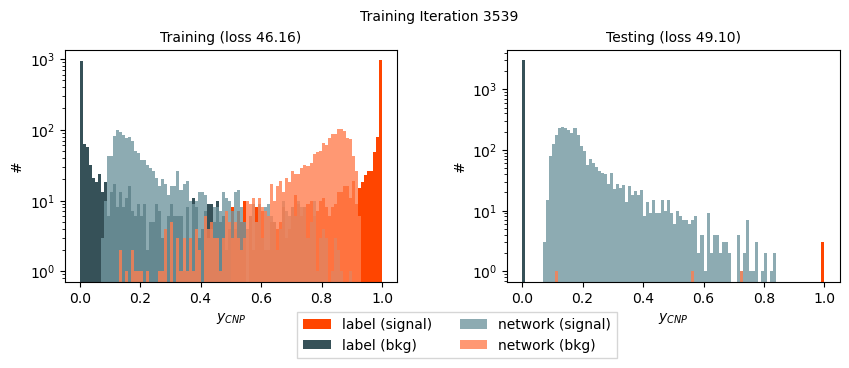

<Figure size 640x480 with 0 Axes>

In [6]:

d_x, d_in, representation_size, d_out = x_size , x_size+y_size, 32, y_size+1
encoder_sizes = [d_in, 32, 64, 128, 128, 128, 64, 48, representation_size]
decoder_sizes = [representation_size + d_x, 32, 64, 128, 128, 128, 64, 48, d_out]

model = cnp.DeterministicModel(encoder_sizes, decoder_sizes)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# 

bce = nn.BCELoss()
iter_testing = 0
fout = open(f'{path_out}{f_out}_training.txt', "w")

# create a PdfPages object
pdf = PdfPages(f'{path_out}{f_out}_training.pdf')

for it in range(TRAINING_ITERATIONS):
    # load data:
    data_train = dataset_train.get_data(it, CONTEXT_IS_SUBSET)

    # Get the predicted mean and variance at the target points for the testing set
    log_prob, mu, _ = model(data_train.query, data_train.target_y)
    
    # Define the loss
    loss = -log_prob.mean()
    loss.backward()

    # Perform gradient descent to update parameters
    optimizer.step()
    
    # reset gradient to 0 on all parameters
    optimizer.zero_grad()

    if max(mu[0].detach().numpy()) <= 1 and min(mu[0].detach().numpy()) >= 0:
        loss_bce = bce(mu, data_train.target_y)
    else:
        loss_bce = -1.

    mu=mu[0].detach().numpy()
    if it % 500 == 0 or it > 3400:
        print('{} Iteration: {}/{}, train loss: {:.4f} (vs BCE {:.4f})'.format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),it, TRAINING_ITERATIONS,loss, loss_bce))
        fout.write('Iteration: {}/{}, train loss: {:.4f} (vs BCE {:.4f})\n'.format(it, TRAINING_ITERATIONS,loss, loss_bce))
    
    if it % PLOT_AFTER == 0 or it == int(TRAINING_ITERATIONS-1) or it > 3500:
        data_testing = dataset_testing.get_data(iter_testing, CONTEXT_IS_SUBSET)
        log_prob_testing, mu_testing, _ = model(data_testing.query, data_testing.target_y)
        # Define the loss
        loss_testing = -log_prob_testing.mean()

        if max(mu_testing[0].detach().numpy()) <= 1 and min(mu_testing[0].detach().numpy()) >= 0:
            loss_bce_testing = bce(mu_testing,  data_testing.target_y)
        else:
            loss_bce_testing = -1.

        mu_testing=mu_testing[0].detach().numpy()
        print("{}, Iteration: {}, test loss: {:.4f} (vs BCE {:.4f})".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it, loss_testing, loss_bce_testing))
        fout.write("{}, Iteration: {}, test loss: {:.4f} (vs BCE {:.4f})\n".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it, loss_testing, loss_bce_testing))
        if isinstance(name_y,str):
            fig = plotting.plot(mu, data_train.target_y[0].detach().numpy(), f'{loss:.2f}', mu_testing, data_testing.target_y[0].detach().numpy(), f'{loss_testing:.2f}', it)
        else:
            for k in range(y_size):
                fig = plotting.plot(mu[:,k], data_train.target_y[0].detach().numpy()[:,k], f'{loss:.2f}', mu_testing[:,k], data_testing.target_y[0].detach().numpy()[:,k], f'{loss_testing:.2f}', it)
        #if it % PLOT_AFTER*5 == 0 or it == int(TRAINING_ITERATIONS-1) or it > 3500:
        if it % PLOT_AFTER*5 == 0 or it == int(TRAINING_ITERATIONS-1) or it > 3500:
            pdf.savefig(fig)
            plt.show()
            plt.clf()
        iter_testing += 1
pdf.close()
fout.close()
torch.save(model.state_dict(), f'./out/{f_out}_model.pth')



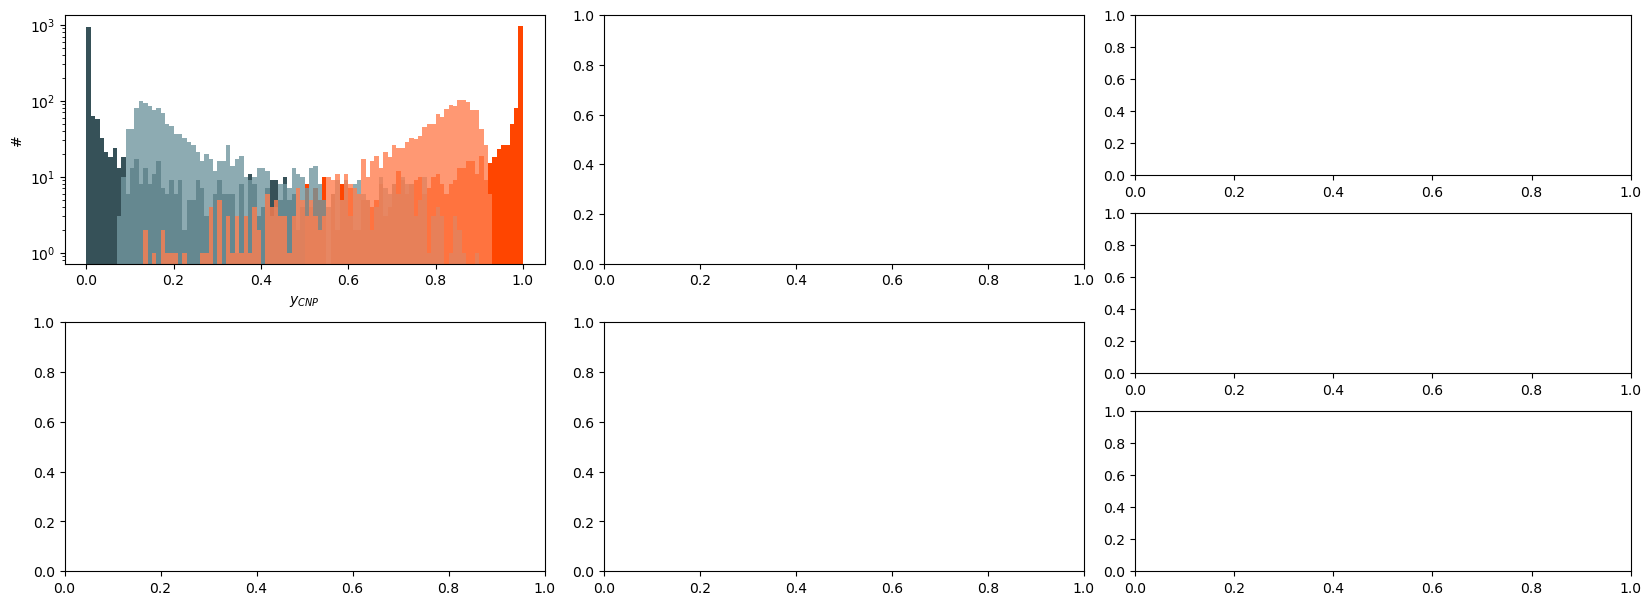

In [7]:
fig = plt.figure(figsize=(16.4,5.94), layout = "constrained")
gs0=fig.add_gridspec(1,2, width_ratios = [2,1])

gs00 = gs0[0].subgridspec(2,2)
gs01 = gs0[1].subgridspec(3,1)
for l in range(2):
    for j in range(2):
        ax = fig.add_subplot(gs00[l,j])
        if l==0 and j==0:
            
            target_y_training = data_train.target_y[0].detach().numpy()
            prediction_y_training = mu
            prediction_y_testing = data_testing.target_y[0].detach().numpy()
            target_y_testing = mu_testing
            index_list_1 = np.where(target_y_testing > 0.5)[0]
            target_signal_testing = np.array([target_y_testing[i] for i in index_list_1])
            prediction_signal_testing = np.array([prediction_y_testing[i] for i in index_list_1])
            target_bkg_testing = np.delete(target_y_testing, index_list_1)
            prediction_bkg_testing = np.delete(prediction_y_testing, index_list_1)

            #######################
            index_list_2 = np.where(target_y_training > 0.5)[0]
            target_signal_training = np.array([target_y_training[i] for i in index_list_2])
            prediction_signal_training = np.array([prediction_y_training[i] for i in index_list_2])
            target_bkg_training = np.delete(target_y_training, index_list_2)
            prediction_bkg_training = np.delete(prediction_y_training, index_list_2)
            bins = 100 
            if len(target_signal_training)>0:
                    ax.hist(target_signal_training, range=[0.0, 1.0],bins=bins, color='orangered', alpha=1.0, label='label (signal)')
            ax.hist(target_bkg_training, range=[0.0, 1.0],bins=bins, color=(3/255,37/255,46/255), alpha=0.8, label='label (bkg)')
            ax.hist(prediction_bkg_training, range=[0.0, 1.0],bins=bins, color=(113/255,150/255,159/255), alpha=0.8, label='network (bkg)')
            if len(target_signal_training)>0:
                    ax.hist(prediction_signal_training, range=[0.0, 1.0],bins=bins, color='coral', alpha=0.8, label='network (signal)')
            
            ax.set_yscale('log')
            ax.set_ylabel('#')
            ax.set_xlabel(r'$y_{CNP}$')

for j in range(3):
    ax = fig.add_subplot(gs01[j])
    
fig.savefig(f"training_distribution_{version_cnp}.png")
